In [1]:
import ujson as json
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import sklearn.cluster as clstr
from sklearn.cluster import KMeans, DBSCAN
import scipy.sparse as sp
from sklearn.metrics import silhouette_score
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
import seaborn as sns
import pandas as pd
import itertools

In [3]:
type_1_files = ['2_train.json', '2_test.json', '1_test.json', '1_train.json']
type_2_files = ['Apsaras3.json', '2_test_2.json']
positions = []
grottoes = []
files = []
ARTIC_NAMES = {'foot 1': 0,
               'foot 2': 1,
               'knee 1': 2,
               'knee 2': 3,
               'belly': 4,
               'elbow 1': 5,
               'elbow 2': 6,
               'hand 1': 7,
               'hand 2': 8,
               'eye 1': 9,
               'eye 2': 10,
               'shoulder 1': 11,
               'shoulder 2': 12}
for f in type_1_files: 
    file = open(f)
    data = json.load(file)
    for i in range(0,len(data)):
        apsara = data[i]
        files.append(apsara['apsaras']['file'])
        grottoes.append(apsara['apsaras']['grottoe'])
        access = apsara['apsaras']['positions']
        position = []
        for articulation in ARTIC_NAMES.keys():
            position.append(access[articulation])
        positions.append(position)

for f in type_2_files: 
    file = open(f)
    data = json.load(file) 
    for apsara in data['apsaras']:
        grottoes.append(apsara['grottoe'])
        files.append(apsara['file'])
        access = apsara['positions']
        position = []
        for articulation in ARTIC_NAMES.keys():
            position.append(access[articulation])
        positions.append(position)
        
positions = np.array(positions)

In [4]:
def plot_line(apsara, a1, a2, ax, c='r'):
    """
    Plot the leg/arm/... between articulations a1 and a2
    """
    i1 = ARTIC_NAMES[a1]
    i2 = ARTIC_NAMES[a2]
    ax.plot(apsara[(i1, i2), 0], apsara[(i1, i2), 1], c)
def plot_pose(apsara, ax=None, c='r'):
    if ax is None:
        fig, ax = plt.subplots()
    plt.gca().invert_yaxis()
    plot_line(apsara, 'foot 1', 'knee 1', ax, c=c)
    plot_line(apsara, 'knee 1', 'belly', ax, c=c)
    plot_line(apsara, 'foot 2', 'knee 2', ax, c=c)
    plot_line(apsara, 'knee 2', 'belly', ax, c=c)
    plot_line(apsara, 'shoulder 1', 'belly', ax, c=c)
    plot_line(apsara, 'shoulder 2', 'belly', ax, c=c)
    plot_line(apsara, 'shoulder 1', 'elbow 1', ax, c=c)
    plot_line(apsara, 'shoulder 2', 'elbow 2', ax, c=c)
    plot_line(apsara, 'elbow 1', 'hand 1', ax, c=c)
    plot_line(apsara, 'elbow 2', 'hand 2', ax, c=c)
    plot_line(apsara, 'shoulder 1', 'shoulder 2', ax, c=c)
    plot_line(apsara, 'eye 1', 'eye 2', ax, c=c)

def plot_all(apsaras, line_length=12, colors=None, labels=None):
    fig, ax = plt.subplots()
    if colors is None:
        for i, apsara in enumerate(apsaras):
            plot_pose(apsara + 5*np.array([[i%line_length, i//line_length]]), ax=ax)
    else:
        for i, apsara in enumerate(apsaras):
            plot_pose(apsara + 5*np.array([[i%line_length, i//line_length]]),
                      ax=ax,
                      #c=colors[labels[i]])
                      c=clr_palette[labels[i]])

In [5]:
def preprocess(data):    
    data = 1.*np.delete(data, np.all(np.all(data==-1, axis=1), axis=1), axis=0)
    data[data==-1] = np.nan
    norm_data = (data - np.nanmean(data, axis=1)[:, None, :]) / np.nanstd(data, axis=1, ddof=1)[:, None, :]
    return -norm_data

def remove_nans(data):
    return np.delete(data, 
                     np.any(np.any(np.isnan(data),
                                   axis=1),
                            axis=1),
                     axis=0)
def prepare_kmeans(data, n_clusters):
    data = remove_nans(preprocess(data))
    flat_data = data.reshape(data.shape[0], -1)
    kmeans = clstr.KMeans(n_clusters=n_clusters).fit(flat_data)
    return kmeans

In [6]:
def make_vec(keypoints, pt1, pt2):
    """
    returns vector pt1->pt2
    """
    slicer = np.zeros(13)
    slicer[ARTIC_NAMES[pt1]] = -1
    slicer[ARTIC_NAMES[pt2]] = 1
    # i: articulation
    # j: apsara n°
    # k: 2D pt coordinate
    return np.einsum("i,jik->jk", slicer, keypoints)

In [7]:
positions.shape

(557, 13, 2)

In [8]:
def angle(vec1, vec2):
    """
    Compute angle between vectors 1 and 2
    vec1 and vec2 are lists of vectors (in np format)
    """
    prod = np.einsum("ij,ij->i", vec1, vec2)
    nrm = np.linalg.norm(vec1, axis=1)\
        * np.linalg.norm(vec2, axis=1)
    return np.arccos(prod / nrm)

In [9]:
def get_angles(keypoints):
    angle_knee1 = angle(make_vec(keypoints, "knee 1", "foot 1"),
                        make_vec(keypoints, "knee 1", "belly"))
    angle_knee2 = angle(make_vec(keypoints, "knee 2", "foot 2"),
                        make_vec(keypoints, "knee 2", "belly"))
    angle_elbow1 = angle(make_vec(keypoints, "elbow 1", "hand 1"),
                         make_vec(keypoints, "elbow 1", "shoulder 1"))
    angle_elbow2 = angle(make_vec(keypoints, "elbow 2", "hand 2"),
                         make_vec(keypoints, "elbow 2", "shoulder 2"))
    angle_shoulder1 = angle(make_vec(keypoints, "shoulder 1", "elbow 1"),
                            make_vec(keypoints, "shoulder 1", "belly"))
    angle_shoulder2 = angle(make_vec(keypoints, "shoulder 2", "elbow 2"),
                            make_vec(keypoints, "shoulder 2", "belly"))
    # I add three more angles as features
    angle_sbk1 = angle(make_vec(keypoints, "belly", "shoulder 1"),
                            make_vec(keypoints, "belly", "knee 1"))
    angle_sbk2 = angle(make_vec(keypoints, "belly", "shoulder 2"),
                            make_vec(keypoints, "belly", "knee 2"))
    angle_kbk = angle(make_vec(keypoints, "belly", "knee 1"),
                            make_vec(keypoints, "belly", "knee 2"))
    return np.stack([angle_knee1,
                    angle_knee2,
                    angle_elbow1,
                    angle_elbow2,
                    angle_shoulder1,
                    angle_shoulder2,
                    angle_sbk1,
                    angle_sbk2,
                    angle_kbk
                    ], axis=1)

In [10]:
agls = get_angles(remove_nans(preprocess(positions)))

## Silhouette score, according to the plot, the optimal k should be 2??

Text(0, 0.5, 'Silhouette score')

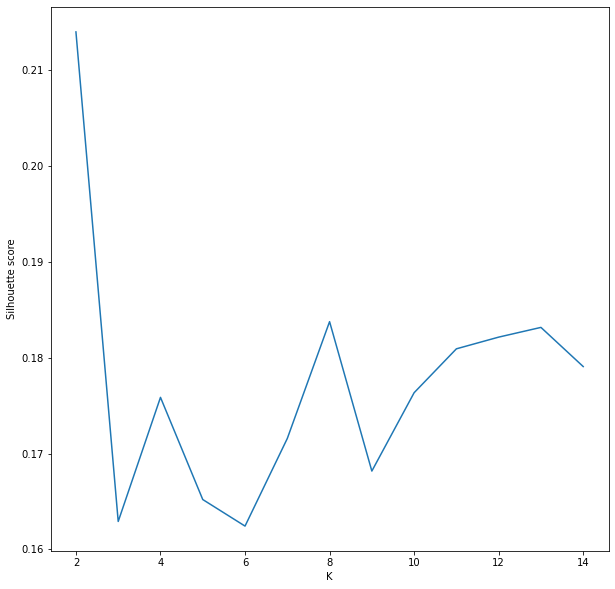

In [11]:
silhouettes = []

# Try multiple k
for k in range(2, 15):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k).fit_predict(agls)
    # Get the Silhouette score
    score = silhouette_score(agls, labels)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")

## Elbow Method, according to the plot, the optimal k should be 3? 5？

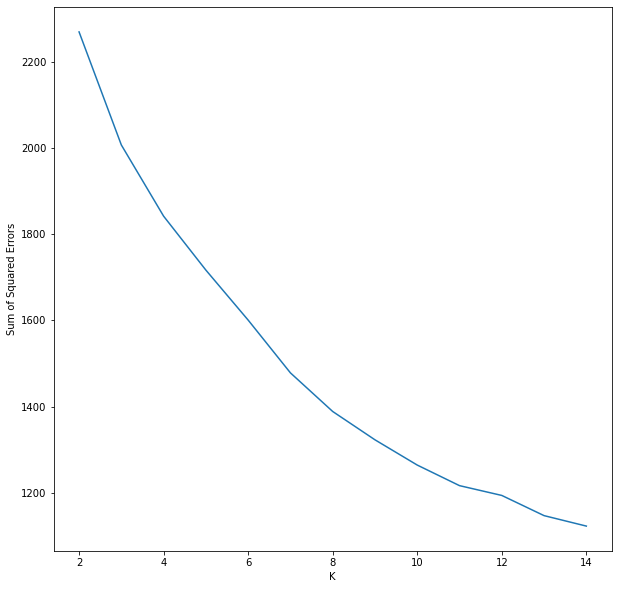

In [12]:
def plot_sse(features_X, start=2, end=15):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(agls)

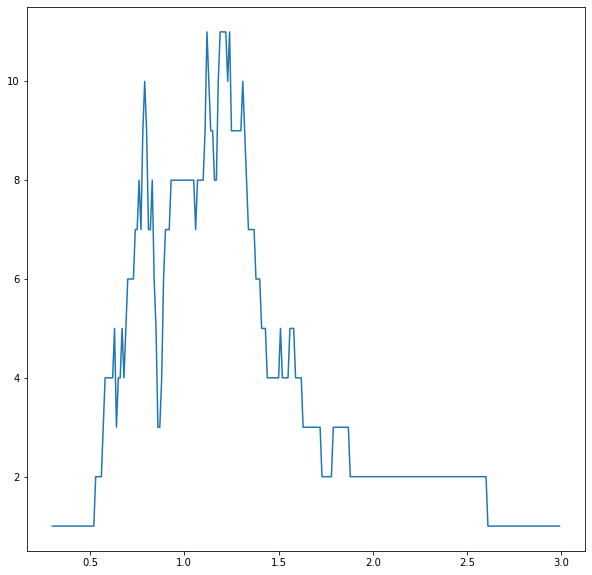

In [13]:
EPS = .01*np.arange(30, 300)
N = []
for eps in EPS:
    N.append(len(set(clstr.DBSCAN(eps=eps).fit(agls).labels_)))

plt.plot(EPS, N)

## I choose neighbors = 14 because it is suggested that neighbors should more than 2xdimension = 2x7 = 14, according to the plot, the optimal epsilon is between 1.5-1.7

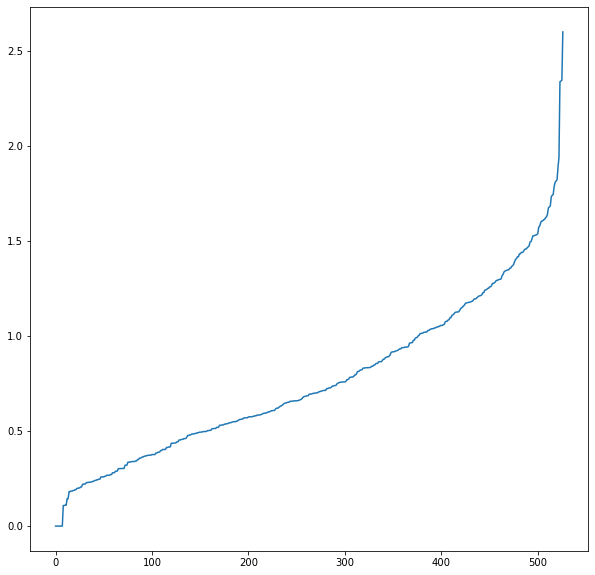

In [26]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
neighbors = NearestNeighbors(n_neighbors=14)
neighbors_fit = neighbors.fit(agls)
distances, indices = neighbors_fit.kneighbors(agls)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [22]:
db = clstr.DBSCAN(eps=1.6, min_samples=14).fit(agls)

In [24]:
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [16]:
# Pick the "core samples" and color them
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

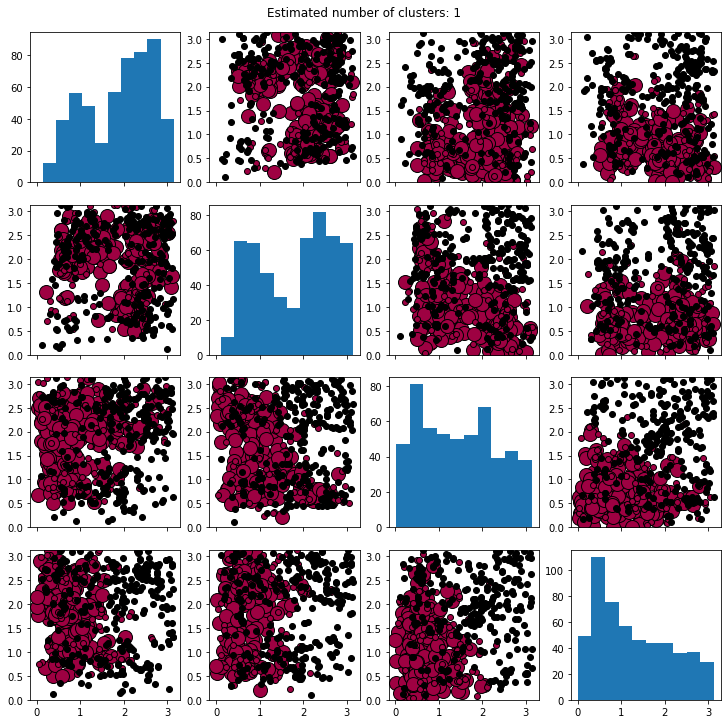

In [17]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig, axs = plt.subplots(4, 4, subplot_kw=dict(box_aspect=1),
                         sharex=True, constrained_layout=True)
for i, j in itertools.product(range(4), range(4)):
    ax = axs[i, j]
    if i==j:
        ax.hist(agls[:, i])
        continue
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = agls[class_member_mask & core_samples_mask]
        ax.plot(
            xy[:, i],
            xy[:, j],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = agls[class_member_mask & ~core_samples_mask]
        ax.plot(
            xy[:, i],
            xy[:, j],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )
        ax.set_ylim([0., np.pi])

fig.suptitle("Estimated number of clusters: %d" % n_clusters_)
plt.show()